In [1]:
#Hello

In [2]:
import os
import pandas as pd
from torch.utils.data import DataLoader
from datetime import datetime

Load Datasets

In [3]:
#Load the fight data
fight_stats_df = pd.read_csv('datasets/ufc_fight_stat_data.csv')

#Load fight data
fight_data_df = pd.read_csv('datasets/ufc_fight_data.csv')

#Load fighter data 
fighter_data_df = pd.read_csv('datasets/ufc_fighter_data.csv')

#Load event data
event_data_df = pd.read_csv('datasets/ufc_event_data.csv')

print(fighter_data_df.columns)

Index(['fighter_id', 'fighter_f_name', 'fighter_l_name', 'fighter_nickname',
       'fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm',
       'fighter_stance', 'fighter_dob', 'fighter_w', 'fighter_l', 'fighter_d',
       'fighter_nc_dq', 'fighter_url'],
      dtype='object')


Clean and Process Data

In [4]:
#Convert data columns to datetime format
fighter_data_df['fighter_dob'] = pd.to_datetime(fighter_data_df['fighter_dob'])

#Handle Missing Value, if any
fight_stats_df = fight_stats_df.dropna(subset=['fighter_id', 'ctrl_time'])
fight_data_df = fight_data_df.dropna(subset=['fight_id', 'f_1', 'f_2', 'winner', 'num_rounds'])
fighter_data_df = fighter_data_df.dropna(subset=['fighter_id', 'fighter_reach_cm', 'fighter_height_cm', 'fighter_stance', 'fighter_dob'])

fighter_data_df['fighter_nc_dq'] = fighter_data_df['fighter_nc_dq'].fillna(0)
fighter_data_df['fighter_stance'] = fighter_data_df['fighter_stance'].fillna(0)

event_data_df = event_data_df.dropna(subset=['event_id'])

#Encode categorical variables (if needed)
fighter_data_df['fighter_stance'] = fighter_data_df['fighter_stance'].map({'Orthodox': 0, 'Southpaw': 1, 'Switch': 2})



Merge Datasets

In [5]:
    
merged_df = pd.merge(fight_stats_df, fight_data_df, how='inner', on='fight_id')
merged_df = pd.merge(merged_df, fighter_data_df, how='inner', on='fighter_id')
merged_df = pd.merge(merged_df, event_data_df, how='inner', on='event_id')


Cleaning

In [6]:
# Convert ctrl_time from minute format to seconds
def time_to_seconds(time_str):
    if time_str == '--':
        return None  # or any other suitable value, like np.nan
    else:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    
merged_df['ctrl_time'] = merged_df['ctrl_time'].apply(time_to_seconds)
merged_df['finish_time'] = merged_df['finish_time'].apply(time_to_seconds)

#Convert each column to unique ID
merged_df['referee'] = pd.factorize(merged_df['referee'])[0]
merged_df['event_city'] = pd.factorize(merged_df['event_city'])[0]
merged_df['event_state'] = pd.factorize(merged_df['event_state'])[0]
merged_df['event_country'] = pd.factorize(merged_df['event_country'])[0]
merged_df['result_details'] = pd.factorize(merged_df['result_details'])[0]
merged_df['title_fight'] = pd.factorize(merged_df['title_fight'])[0]
merged_df['weight_class'] = pd.factorize(merged_df['weight_class'])[0]
merged_df['gender'] = pd.factorize(merged_df['gender'])[0]
merged_df['result'] = pd.factorize(merged_df['result'])[0]

# NOTE: add column that contains value age at the event date

# Convert num_rounds to int
merged_df['num_rounds'] = pd.to_numeric(merged_df['num_rounds'], errors='coerce')


# Convert dob to age in years at the date of 3/25/2024
hard_coded_datetime = datetime(2024, 3, 25)
merged_df['fighter_dob'] = (hard_coded_datetime.date() - pd.to_datetime(merged_df['fighter_dob']).dt.date).apply(lambda x: x.days / 365.25)


# List of columns to drop (temp drop 'event_date' *add later*)
cols_to_drop = ['fight_url_x', 'fighter_url', 'event_url', 'fight_url_x', 
                'fight_url_y', 'event_url', 'fighter_url', 'event_name', 
                'fighter_nickname', 'fighter_l_name', 'fighter_f_name', 
                'event_date', 'event_state', 'fight_id', 'finish_round',
                'result_details'
                ]

# Drop the specified columns
merged_df = merged_df.drop(columns=cols_to_drop)



Create Cumulative Columns

In [7]:
#create cumulative column for ctrl_time

# merged_df.sort_values(by=["fighter_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
merged_df["avg_ctrl_time"] = merged_df.groupby("fighter_id")["ctrl_time"].transform(lambda x: x.expanding().mean())
# Cumulative for reversals
merged_df["avg_reversals"] = merged_df.groupby("fighter_id")["reversals"].transform(lambda x: x.expanding().mean())

# for submission attempts
merged_df["avg_submission_att"] = merged_df.groupby("fighter_id")["submission_att"].transform(lambda x: x.expanding().mean())

# for takedown succession
merged_df["avg_takedown_succ"] = merged_df.groupby("fighter_id")["takedown_succ"].transform(lambda x: x.expanding().mean())

# for takedown attmepts 
merged_df["avg_takedown_att"] = merged_df.groupby("fighter_id")["takedown_att"].transform(lambda x: x.expanding().mean())

# for significant strike succession
merged_df["avg_sig_strikes_att"] = merged_df.groupby("fighter_id")["sig_strikes_att"].transform(lambda x: x.expanding().mean())

# for total strikes succession
merged_df["avg_total_strikes_succ"] = merged_df.groupby("fighter_id")["total_strikes_succ"].transform(lambda x: x.expanding().mean())

# for total strikes ATTEMPTS
merged_df["avg_total_strikes_att"] = merged_df.groupby("fighter_id")["total_strikes_att"].transform(lambda x: x.expanding().mean())

# for knockdowns
merged_df["avg_knockdowns"] = merged_df.groupby("fighter_id")["knockdowns"].transform(lambda x: x.expanding().mean())

# AVG finish Time
merged_df['avg_finish_time'] = merged_df.groupby('fighter_id')['finish_time'].transform(lambda x: x.expanding().mean())


# merged_df = pd.read_csv('final_set.csv')

print(merged_df.columns)
# print("num of columns" , merged_df.shape[1])
# print(merged_df['finish_time'])

merged_df.to_csv('final_set(2).csv', index=False)


Index(['fight_stat_id', 'fighter_id', 'knockdowns', 'total_strikes_att',
       'total_strikes_succ', 'sig_strikes_att', 'sig_strikes_succ',
       'takedown_att', 'takedown_succ', 'submission_att', 'reversals',
       'ctrl_time', 'event_id', 'referee', 'f_1', 'f_2', 'winner',
       'num_rounds', 'title_fight', 'weight_class', 'gender', 'result',
       'finish_time', 'fighter_height_cm', 'fighter_weight_lbs',
       'fighter_reach_cm', 'fighter_stance', 'fighter_dob', 'fighter_w',
       'fighter_l', 'fighter_d', 'fighter_nc_dq', 'event_city',
       'event_country', 'avg_ctrl_time', 'avg_reversals', 'avg_submission_att',
       'avg_takedown_succ', 'avg_takedown_att', 'avg_sig_strikes_att',
       'avg_total_strikes_succ', 'avg_total_strikes_att', 'avg_knockdowns',
       'avg_finish_time'],
      dtype='object')


Remove original numeric stats

In [8]:
# Need to remove original numeric stats because they are independent and would be hard to implement when creating features for model
temp_df = pd.read_csv('final_set(2).csv')

drop_cols = ['knockdowns', 'total_strikes_att', 'total_strikes_succ',
            'sig_strikes_att', 'sig_strikes_succ', 'takedown_att',
            'takedown_succ', 'submission_att', 'reversals', 'ctrl_time',
            'event_id', 'result', 'finish_time'
            ]
# temp_df = temp_df[temp_df['fight_stat_id'] > 1200]
temp_df = merged_df.drop(columns=drop_cols)
temp_df = temp_df.iloc[:10550]
temp_df.sort_values(by=["fighter_id", 'fight_stat_id'], ascending=[True, True], inplace=True)
temp_df.to_csv('final_set(2).csv', index=False)

Random Forest Algo

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

merged_df = pd.read_csv('final_set(2).csv')
data = merged_df
df = pd.DataFrame(data)

# Creating a binary target variable indicating whether the fighter won or not.
df['is_winner'] = df['fighter_id'] == df['winner']

# Selecting features for the model
features = [
    "f_1","f_2","num_rounds", "title_fight", "weight_class", "gender", 
    "fighter_height_cm", "fighter_weight_lbs", "fighter_reach_cm", 
    "fighter_stance", "fighter_w", "fighter_l", "fighter_d", "fighter_dob",
    'avg_ctrl_time', 'avg_reversals', 'avg_submission_att', 
    'avg_takedown_succ', 'avg_takedown_att', 'avg_sig_strikes_att',
    'avg_total_strikes_succ', 'avg_total_strikes_att', 'avg_knockdowns',
    'avg_finish_time'
]
X = df[features]
y = df['is_winner']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the feature set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predicting and evaluating the model
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Accuracy: 0.6625592417061611


In [10]:
import numpy as np

# Example feature arrays for f_1 and f_2
# These should include all the features used by your model, except the 'fighter_id'.
data_f1 = np.array([[2902,2532,5,1,0,0,180.34,155.0,177.8,0.0,25,4,0,35.35934291581109,21.416666666666668,0.0,0.0,0.08333333333333333,0.3333333333333333,119.08333333333333,73.83333333333333,121.75,0.5,185.83333333333334]]) # Justin    
data_f2 = np.array([[2532,2902,5,1,0,0,180.34,145.0,175.26,0.0,25,7,0,32.3066392881588,59.76,0.0,0.4,0.32,0.6,251.64,131.28,262.52,0.32,259.12]]) # Max

# Scale the data using the existing scaler
data_f1_scaled = scaler.transform(data_f1)
data_f2_scaled = scaler.transform(data_f2)

# Predict the outcomes using the trained classifier
pred_f1 = clf.predict_proba(data_f1_scaled)[0][1]  # Probability of f_1 winning
pred_f2 = clf.predict_proba(data_f2_scaled)[0][1]  # Probability of f_2 winning

# Compare the probabilities and print the winner
if pred_f1 > pred_f2:
    print("Winner is f_1 with probability:", pred_f1)
else:
    print("Winner is f_2 with probability:", pred_f2)


Winner is f_1 with probability: 0.91


/home/kyle/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/kyle/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Preprocessing for Neural Network

In [11]:
import numpy as np
import pandas as pd

#X_train_scaled is a numpy array; convert it to a DataFrame for easier manipulation
df_train_features = pd.DataFrame(X_train_scaled)

# Handling NaN values by imputation
df_train_features.fillna(df_train_features.mean(), inplace=True)

# Handling infinite values by replacing them with NaN and then imputing
df_train_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train_features.fillna(df_train_features.mean(), inplace=True)

# Convert back to numpy array if necessary
X_train_scaled_clean = df_train_features.to_numpy()


Check for NaNs or infinite values in numpy


In [12]:
# Example check for NaNs or infinite values in numpy
import numpy as np

# Assuming X_train_scaled is a numpy array
if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print("Training features contain NaN or infinite values.")
if np.isnan(y_train.values).any():
    print("Training labels contain NaN values.")
    

Neural Network

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


# Convert data to PyTorch tensors, ensuring y_train and y_test are converted from pandas Series to numpy arrays first
X_train_tensor = torch.tensor(X_train_scaled).float()
y_train_tensor = torch.tensor(y_train.to_numpy()).long()  
X_test_tensor = torch.tensor(X_test_scaled).float()
y_test_tensor = torch.tensor(y_test.to_numpy()).long()

# Creating Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Splitting train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Neural Network Model with Dropout
class FightPredictor(nn.Module):
    def __init__(self):
        super(FightPredictor, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 128)
        self.dropout1 = nn.Dropout(0.5)  # Adding dropout
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)  # Adding dropout
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = FightPredictor()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training with Early Stopping
num_epochs = 70
best_val_loss = float('inf')

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)

    # Validation loss
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    validation_loss = val_loss / len(val_loader)
    validation_losses.append(validation_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), 'best_test_model(2).pth')
    
    scheduler.step()  # Update learning rate
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

# Load the best model for testing
model.load_state_dict(torch.load('best_test_model(2).pth'))

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test dataset: {100 * correct / total}%')


Epoch 1/70, Training Loss: 0.6402927867646487, Validation Loss: 0.5992995213579249
Epoch 2/70, Training Loss: 0.6179744404441906, Validation Loss: 0.5952191330768444
Epoch 3/70, Training Loss: 0.6144878698407479, Validation Loss: 0.589755755883676
Epoch 4/70, Training Loss: 0.6140466231220173, Validation Loss: 0.5936468376053704
Epoch 5/70, Training Loss: 0.6095126636748044, Validation Loss: 0.5861635616532078
Epoch 6/70, Training Loss: 0.6106544302881889, Validation Loss: 0.6039517830919336
Epoch 7/70, Training Loss: 0.6051235710674862, Validation Loss: 0.5778263983903108
Epoch 8/70, Training Loss: 0.6048118199379939, Validation Loss: 0.5773287680413988
Epoch 9/70, Training Loss: 0.6059386707701773, Validation Loss: 0.5972081444881581
Epoch 10/70, Training Loss: 0.6066352311732635, Validation Loss: 0.5941114381507591
Epoch 11/70, Training Loss: 0.5914097175283252, Validation Loss: 0.5877186744301407
Epoch 12/70, Training Loss: 0.5855709845727345, Validation Loss: 0.5825753432733042
Ep

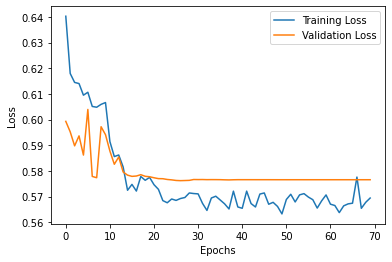

In [14]:
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Testing New Unseen Data

In [21]:
import numpy as np

# Example feature arrays for two fighters (ensure these feature arrays match the input dimensions expected by the model)
data_f1 = np.array([[332,1644,3,0,0,0,190.5,155.0,195.58,1.0,13,7,0,28.854209445585216,65.6,0.1,0.7,0.4,0.8,87.1,51.3,97.9,0.5,195.8]]) # Turner 
data_f2 = np.array([[1644,322,3,0,0,0,180.34,155.0,182.88,0.0,17,5,1,34.84462696783025,65.71428571428571,0.0,0.42857142857142855,1.0,2.142857142857143,90.14285714285714,48.642857142857146,96.64285714285714,0.07142857142857142,199.42857142857142]]) # Moicano

# Convert numpy arrays to PyTorch tensors
data_f1_tensor = torch.tensor(data_f1).float()
data_f2_tensor = torch.tensor(data_f2).float()

# Predict the outcomes using the trained neural network
model.load_state_dict(torch.load('best_test_model.pth'))
model.eval()
with torch.no_grad():
    pred_f1 = model(data_f1_tensor)
    pred_f2 = model(data_f2_tensor)
    prob_f1 = torch.nn.functional.softmax(pred_f1, dim=1)[:, 1]  # Probability of f_1 winning
    prob_f2 = torch.nn.functional.softmax(pred_f2, dim=1)[:, 1]  # Probability of f_2 winning

# Compare the probabilities and print the winner
if prob_f1 > prob_f2:
    print("Winner is f_1 ")
else:
    print("Winner is f_2 ")


Winner is f_1 


In [16]:
# model = FightPredictor()
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval

In [17]:
# new_fight_features = [2980,7,5,1,1,0,180.34,155.0,177.8,0.0,25,4,0,35.35934291581109,257.0,0.0,0.0,1.0,4.0,1429.0,886.0,1461.0,6.0,185.83333333333334]
# new_fight_data_scaled = scaler.transform([new_fight_features])
# new_fight_tensor = torch.tensor(new_fight_data_scaled).float()


In [18]:
# with torch.no_grad():
#     prediction = model(new_fight_tensor)
#     predicted_winner = torch.argmax(prediction, dim=1).item()

# # Assuming 0 represents f_1 and 1 represents f_2 as the winner
# winner = "f_1" if predicted_winner == 0 else "f_2"
# print(f"Predicted winner: {winner}")
# print(winner)

In [19]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X_train_tensor = torch.tensor(X_train_scaled).float()
# y_train_tensor = torch.tensor(y_train.to_numpy()).long()  
# X_test_tensor = torch.tensor(X_test_scaled).float()
# y_test_tensor = torch.tensor(y_test.to_numpy()).long()

# # Creating Dataset and DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)



In [20]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Features used in the model
features = [
    "f_1", "f_2", "num_rounds", "title_fight", "weight_class", "gender",
    "fighter_height_cm", "fighter_weight_lbs", "fighter_reach_cm",
    "fighter_stance", "fighter_w", "fighter_l", "fighter_d", "fighter_dob",
    'avg_ctrl_time', 'avg_reversals', 'avg_submission_att',
    'avg_takedown_succ', 'avg_takedown_att', 'avg_sig_strikes_att',
    'avg_total_strikes_succ', 'avg_total_strikes_att', 'avg_knockdowns',
    'avg_finish_time'
]

# Data for prediction
data = [
    2902,2532,5,1,1,0,180.34,155.0,177.8,0.0,25,4,0,35.35934291581109,257.0,0.0,0.0,1.0,4.0,1429.0,886.0,1461.0,6.0,185.83333333333334

]

# Create DataFrame with proper columns
df = pd.DataFrame([data], columns=features)

# Initialize and fit scaler on the new data (this is a fallback, not recommended)
scaler = StandardScaler()
scaler.fit(df)  # Fit scaler to new data

# Scale the data
X_scaled = scaler.transform(df)

# Convert scaled data to PyTorch tensor
X_new = torch.tensor(X_scaled).float()

# Load the best model
model = FightPredictor()
model.load_state_dict(torch.load('best_test_model.pth'))
model.eval()

# Predict
with torch.no_grad():
    outputs = model(X_new)
    _, predicted = torch.max(outputs.data, 1)

# Display Predicted Class
print("Predicted Class:", predicted.item())  # 0 for f_1 wins, 1 for f_2 wins


Predicted Class: 1
